# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Convolutional neural networks

Inspiration for this notebook is taken from YSDA materials

__Colab is highly recommended to work with this notebook__

### About CNNs
Convolutional layers extract features - quantitative representations of some attributes.

After the extraction you can use these features for classification, for example.

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/act.png?raw=1" width="800">

#### Convolution:
<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/convolution.gif?raw=1" width="400">

### Pooling:
<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/pooling.gif?raw=1" width="400">


## Deeper layer $\to$ more complex features.

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/feat.png?raw=1" width="800">

# Task: Cats vs. Dogs Classification

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/cat_dog_sota.jpg?raw=1" width="600">




Let's try to build a small convolutional neural network capable of separating cat images from dog images.

## Datasets in pyTorch

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.

- For images, packages such as *Pillow*, *OpenCV* are useful
- For audio, packages such as *scipy* and *librosa*
- For text, either raw *Python* or *Cython* based loading, or *NLTK* and *SpaCy* are useful

We are dealing with images, so let's have a look at image data loading in pyTorch for [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats) classification competition.

The link for data downloading is in the cell below.

Training set size is reduced for performace. If you have enough computational resources, use [this link](https://www.dropbox.com/s/h2vhfxb0j3eazu1/train.zip) for downloading instead of the latter one.

In [ ]:
# Uncomment only on google collab

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Training set with 11K images
! wget -nc https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
! unzip -n -qq data.zip -d data
! mkdir img
! wget -nc https://github.com/girafe-ai/intro-to-ml-harbour/raw/master/day12_Convolutional_neural_networks/img/example_1.png -P img
! wget -nc https://github.com/girafe-ai/intro-to-ml-harbour/raw/master/day12_Convolutional_neural_networks/img/example_2.png -P img

--2025-03-01 08:31:38--  https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/r9f0i63e2wwoaeb9wwsa8/data.zip?rlkey=gb8l615dfj619cg9wc4n4yujz [following]
--2025-03-01 08:31:38--  https://www.dropbox.com/scl/fi/r9f0i63e2wwoaeb9wwsa8/data.zip?rlkey=gb8l615dfj619cg9wc4n4yujz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data.zip’

data.zip                [ <=>                ] 153.33K  --.-KB/s    in 0.06s   

2025-03-01 08:31:38 (2.64 MB/s) - ‘data.zip’ saved [157010]

[data.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the 

Now let's look at the way datasets are processed in PyTorch.

In [ ]:
!pip install torchinfo

In [ ]:
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
from torchinfo import summary
from tqdm import tqdm_notebook as tqdm

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
device.type, device.index, str(device)

('cuda', None, 'cuda')

Images should be stored class-wise in PC memory: each image class have to be represented as a subfolder with the corresponding image data. `ImageFolder` https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html takes the path to 'root' directory of such structure, e.g. DATA_PATH:

- DATA_PATH/dog/xxx.png
- DATA_PATH/dog/xxy.png
- DATA_PATH/dog/xxz.png
- DATA_PATH/cat/123.png
- DATA_PATH/cat/nsdf3.png
- DATA_PATH/cat/asd932_.png

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

Dataset images are of different size.

Batch generator expects a batch of tensors of the same dimensions, thus we need to rescale images in the dataset during data loading.

Let's see at the image size distributions.

In [ ]:
# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 96  # 128 / 192
N_CHANNELS = 3

# Number of classes in the dataset
NUM_CLASSES = 2

# B G R
# Images mean and std channelwise : ImageNet DB
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]

Let's define a transformer to be used as image preprocessing step prior to creating pyTorch image dataset

ToTensor operations:
- convert from numpy to pytorch
- move channels dimension from last position to first
- convert integer representation to float32

In [ ]:
transformer = transforms.Compose(
    [
        transforms.Resize((SIZE_H, SIZE_W)),  # scaling images to fixed size
        transforms.ToTensor(),  # converting to tensors
        transforms.Normalize(image_mean, image_std),  # normalize image data per-channel
    ]
)

Create an ImageFolder instance to be used during training, validation and testing phases.

Pathlib documentation
https://docs.python.org/3/library/pathlib.html

In [ ]:
from pathlib import Path

In [ ]:
# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = Path("data").resolve()
DATA_PATH

PosixPath('/content/data')

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(
    DATA_PATH / "train_11k", transform=transformer
)
val_dataset = torchvision.datasets.ImageFolder(
    DATA_PATH / "val", transform=transformer
)
test_dataset = torchvision.datasets.ImageFolder(
    DATA_PATH / "test_labeled", transform=transformer
)

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/train_11k'

In [ ]:
type(train_dataset)

torchvision.datasets.folder.ImageFolder

In [ ]:
# print(len(train_dataset) * np.multiply(*train_dataset[0][0].size))
len(train_dataset), train_dataset[0][0].shape

(11250, torch.Size([3, 96, 96]))

In [ ]:
# Train dataset size
11250 * 3 * 96 * 96 * 32 / 8 / 2**10 / 2**10 / 2**10 # Gb

1.1587142944335938

In [ ]:
train_dataset.class_to_idx

{'cat': 0, 'dog': 1}

Save sample num for further use

In [ ]:
n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)
n_train, n_val, n_test

(11250, 2500, 12494)

Now let's create a DataLoader instance, which uses ImageFolder instance to generate batches of data.

In [ ]:
# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 256

# Number of threads for data loader
NUM_WORKERS = 2 # 2 is optimal for google colab, for local machine use 4

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

Let's create a helper function to vizualize images from our data loaders (and also make sure data was properly loaded).

In [ ]:
def plot_from_loader(loader):
    iterator = iter(loader)
    data_batch, label_batch = next(iterator)
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15, 10)
    class_names = loader.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        # read images from batch to numpy.ndarray and change axes order [C, H, W] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])

        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)

        # display batch samples with labels
        sample_title = "Label = %d (%s)" % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)

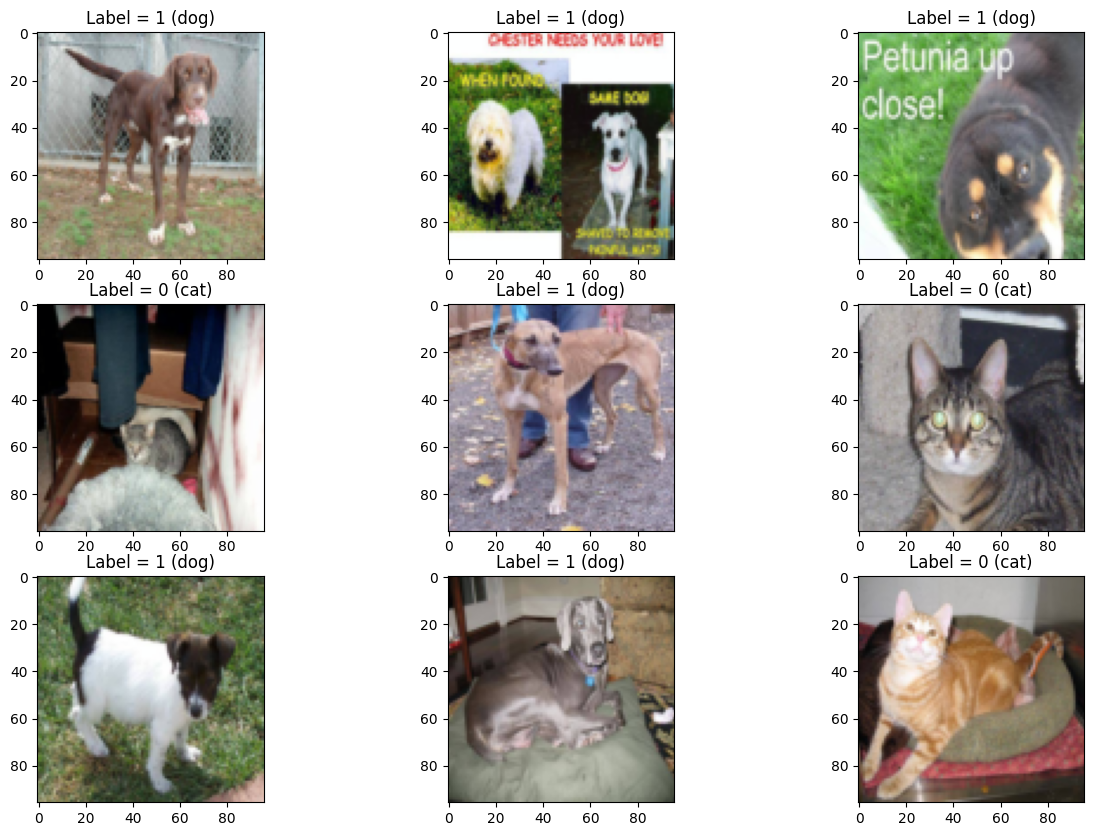

In [ ]:
plot_from_loader(train_loader)

# Building training pipeline

Training function is same to which we used on previous seminar

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    top_val_accuracy = -1
    best_model = None

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        ### TRAINING PHASE
        model.train(True)  # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            # X_batch.cuda() - highly not recommended!
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            ## FORWARD PASS
            opt.zero_grad()
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            predicts = model(X_batch)
            loss = loss_fn(predicts, y_batch)
            ## <\FORWARD PASS>

            ## BACKWARD PASS
            loss.backward()
            opt.step()
            ## </BACKWARD PASS>
            ep_train_loss.append(loss.item())

        ### VALIDATION PHASE
        model.train(False)  # disable dropout / use averages for batch_norm
        with torch.no_grad(): # alternatively https://pytorch.org/docs/stable/generated/torch.autograd.grad_mode.inference_mode.html
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # compute predictions
                preds = model(X_batch)
                validation_loss = loss_fn(preds, y_batch)

                ep_val_loss.append(validation_loss.item())
                # y_pred = preds.max(1)[1].data
                preds_np = np.argmax(preds.detach().cpu().numpy(), 1).ravel()
                gt = y_batch.detach().cpu().numpy().ravel()
                hits = np.array(preds_np == gt)
                ep_val_accuracy.append(hits.astype(np.float32).mean())

        # print the results for this epoch:
        print(f"Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s")

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {100 * val_accuracy[-1]:.1f}")
        if val_accuracy[-1] > top_val_accuracy:
            best_model = model

    return train_loss, val_loss, val_accuracy, best_model

In [ ]:
@torch.no_grad()
def test_model(model, test_loader, subset="test"):
    model.train(False)  # disable dropout / use averages for batch_norm
    test_batch_acc = []

    for X_batch, y_batch in test_loader:
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

    test_accuracy = np.mean(test_batch_acc)

    print("Results:")
    print(f"    {subset} accuracy: {test_accuracy * 100:.2f} %")

    if test_accuracy > 0.9:
        print("  Amazing!")
    elif test_accuracy > 0.7:
        print("  Good!")
    else:
        print("  We need more magic! Follow instructons below")

    return test_accuracy

## Task 0: Multi-layer fully-connected network

Look at the NN structure proposed below.

We will use this model as a baseline for classification task.

As you already know, fully-connetcted networks are not translation invariant and perform worse on image data, so resulting accuracy will be lower than for convolutional neural networks.

In [ ]:
N_CHANNELS * SIZE_H * SIZE_W

27648

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(N_CHANNELS * SIZE_H * SIZE_W, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    # nn.Dropout(0.5),
    nn.Linear(128, NUM_CLASSES),
    nn.Softmax(dim=1),
)

model = model.to(device)

Print model summary for sanity check:

In [ ]:
!nvidia-smi

Sat Jan 18 07:59:26 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0              26W /  70W |    133MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
summary(model, (1, N_CHANNELS, SIZE_H, SIZE_W), device=device)
# [27648 x 256]

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─Flatten: 1-1                           [1, 27648]                --
├─Linear: 1-2                            [1, 256]                  7,078,144
├─ReLU: 1-3                              [1, 256]                  --
├─Linear: 1-4                            [1, 128]                  32,896
├─ReLU: 1-5                              [1, 128]                  --
├─Linear: 1-6                            [1, 2]                    258
├─Softmax: 1-7                           [1, 2]                    --
Total params: 7,111,298
Trainable params: 7,111,298
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 7.11
Input size (MB): 0.11
Forward/backward pass size (MB): 0.00
Params size (MB): 28.45
Estimated Total Size (MB): 28.56

## Training

* We got 11k images (22k for full train set), that's way too many for a full-batch SGD. Let's train on minibatches instead
* For visualization purposes we propose to plot train/val loss graphs and validation score distribution for CNN predictions over images of cats (class_0) and dogs (class_1).

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss, val_loss, val_accuracy, best_model = train_model(
    model, train_loader, val_loader, loss_fn, opt, 5
)

Epoch 1 of 5 took 31.063s
	  training loss: 0.732898
	validation loss: 0.763901
	validation accuracy: 54.7
Epoch 2 of 5 took 36.514s
	  training loss: 0.703199
	validation loss: 0.736060
	validation accuracy: 57.2
Epoch 3 of 5 took 39.444s
	  training loss: 0.699588
	validation loss: 0.758204
	validation accuracy: 55.3
Epoch 4 of 5 took 33.895s
	  training loss: 0.695874
	validation loss: 0.742257
	validation accuracy: 56.9
Epoch 5 of 5 took 32.444s
	  training loss: 0.696411
	validation loss: 0.744727
	validation accuracy: 56.5


In [ ]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title("Loss")
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()
    axes[0].grid()

    axes[1].set_title("Validation accuracy")
    axes[1].plot(val_accuracy)
    axes[1].grid()

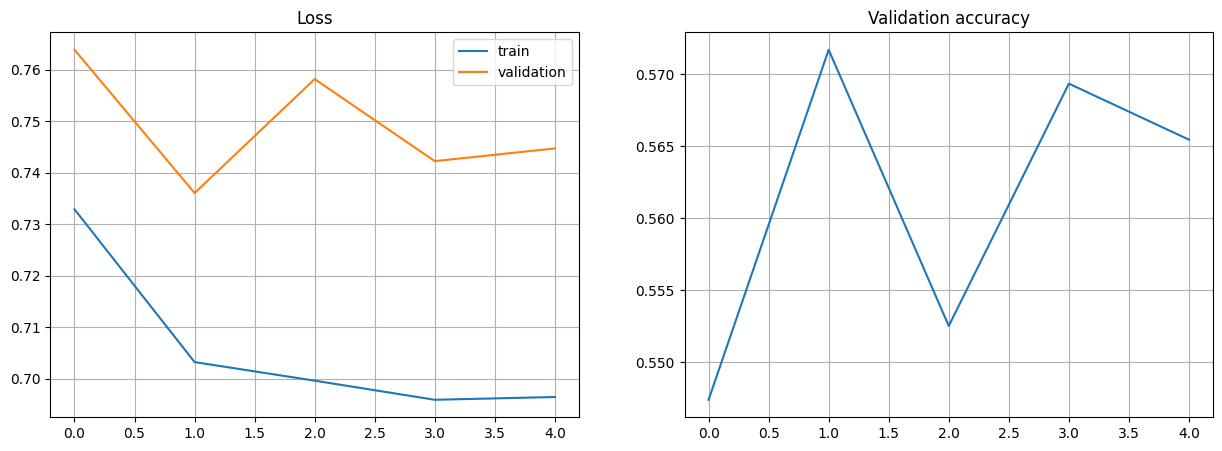

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Evaluate the best model using test set

In [ ]:
val_stats = test_model(best_model, val_loader, "validation")
test_stats = test_model(best_model, test_loader, "test")

Results:
    validation accuracy: 56.55 %
  We need more magic! Follow instructons below
Results:
    test accuracy: 58.30 %
  We need more magic! Follow instructons below


# Task I: small convolution net
## First step

**conv-pool-conv-pool-dense-dense-everybody!**

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 4 classic convolutional blocks `convolution->relu->pool`:
  * 3x3 convolution with 32 -> 32 -> 64 -> 128 filters and _ReLU_ activation
  * 2x2 pooling (or set previous convolution stride to 3)
 * Flatten
* 30% Dropout
* Dense layer with 128 neurons and _ReLU_ activation
* 30% dropout
* Output dense layer.

__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with learning_rate=3e-4 (Karpathy Constant)

If everything is right, you should get at least __75%__ validation accuracy.

__HACK_OF_THE_DAY__ :the number of channels must be in the order of the number of class_labels

__HACK_OF_THE_DAY_2__ : you may set stride=2 for Conv2d layers to increase learning speed, but keep in mind tensor shapes

__HACK_OF_THE_DAY_3__  : it might be useful to use 'VGG-like' structure as a baseline for this task:
    * every CNN layer with 2x2 maxpooling / stride=2 should be followed by increasing the number of output channels x2
    * before the fully-connected layer the tensor H and W should be relatively small (less than 10)
    * in other words, the less H and W of tensor are, the more should you increase C in order to keep more information

LazyLinear layer:\
https://pytorch.org/docs/stable/generated/torch.nn.LazyLinear.html

In [ ]:
# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 256

In [ ]:
model_cnn = nn.Sequential(
    nn.Conv2d(3, 32, 3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, 3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(6),
    nn.Flatten(),
    nn.LazyLinear(EMBEDDING_SIZE),
    nn.Linear(EMBEDDING_SIZE, NUM_CLASSES, bias=False),
    nn.Softmax(dim=1),
)

model_cnn.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): ReLU()
  (10): AdaptiveAvgPool2d(output_size=6)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): LazyLinear(in_features=0, out_features=256, bias=True)
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=256, out_features=2, bias=False)
  (15): Softmax(dim=1)
)


__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

Let's see the basic structure of our model and at the same time perform a sanity check for tensor dimensions.

In [ ]:
summary(model_cnn, (BATCH_SIZE, N_CHANNELS, SIZE_H, SIZE_W), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [256, 2]                  --
├─Conv2d: 1-1                            [256, 32, 48, 48]         896
├─ReLU: 1-2                              [256, 32, 48, 48]         --
├─Conv2d: 1-3                            [256, 64, 48, 48]         18,496
├─ReLU: 1-4                              [256, 64, 48, 48]         --
├─Conv2d: 1-5                            [256, 64, 24, 24]         36,928
├─ReLU: 1-6                              [256, 64, 24, 24]         --
├─Conv2d: 1-7                            [256, 128, 24, 24]        73,856
├─ReLU: 1-8                              [256, 128, 24, 24]        --
├─Conv2d: 1-9                            [256, 128, 12, 12]        147,584
├─ReLU: 1-10                             [256, 128, 12, 12]        --
├─AdaptiveAvgPool2d: 1-11                [256, 128, 6, 6]          --
├─Flatten: 1-12                          [256, 4608]               

## Training

We may use the same training pipeline, that we defined above, as it does not depend on model structure.

In [ ]:
opt = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)

train_loss, val_loss, val_accuracy, best_model_cnn = train_model(
    model_cnn, train_loader, val_loader, loss_fn, opt, 10
)

Epoch 1 of 10 took 32.738s
	  training loss: 0.651377
	validation loss: 0.655668
	validation accuracy: 61.7
Epoch 2 of 10 took 37.897s
	  training loss: 0.604823
	validation loss: 0.618143
	validation accuracy: 66.6
Epoch 3 of 10 took 32.022s
	  training loss: 0.568182
	validation loss: 0.599702
	validation accuracy: 69.1
Epoch 4 of 10 took 33.269s
	  training loss: 0.558127
	validation loss: 0.575452
	validation accuracy: 71.9
Epoch 5 of 10 took 32.117s
	  training loss: 0.538943
	validation loss: 0.559304
	validation accuracy: 73.8
Epoch 6 of 10 took 34.058s
	  training loss: 0.514885
	validation loss: 0.560446
	validation accuracy: 73.9
Epoch 7 of 10 took 33.462s
	  training loss: 0.499832
	validation loss: 0.559368
	validation accuracy: 73.1
Epoch 8 of 10 took 33.905s
	  training loss: 0.494396
	validation loss: 0.547457
	validation accuracy: 74.8
Epoch 9 of 10 took 32.344s
	  training loss: 0.482344
	validation loss: 0.526071
	validation accuracy: 77.5
Epoch 10 of 10 took 35.553s


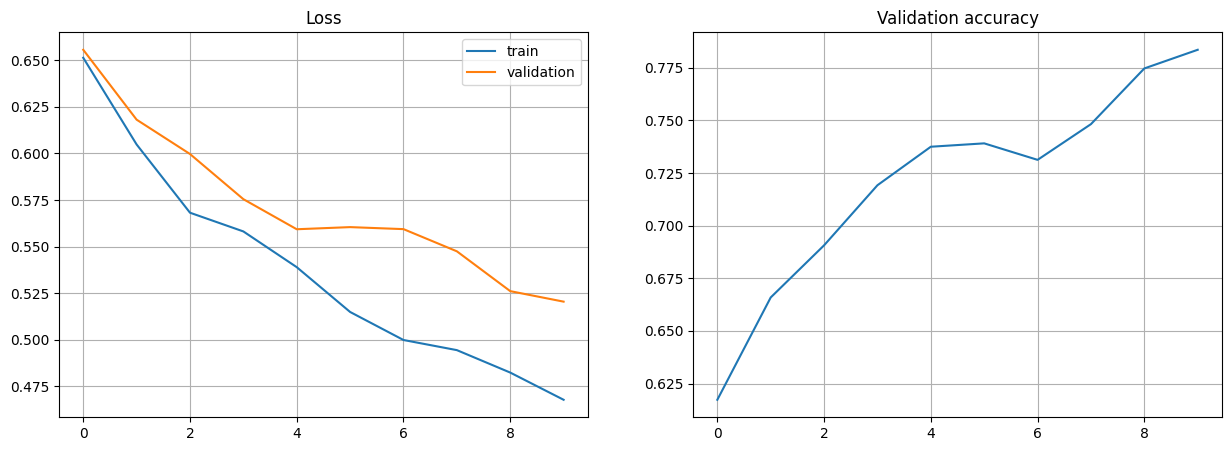

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

**A kind reminder again:** don't wait for too many  epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.

## Evaluation


In [ ]:
val_stats = test_model(best_model_cnn, val_loader, "validation")
test_stats = test_model(best_model_cnn, test_loader, "test")

Results:
    validation accuracy: 78.36 %
  Good!
Results:
    test accuracy: 79.66 %
  Good!


### A bit better conv model

TODO: make batch size bigger!

In [ ]:
model_better_cnn = nn.Sequential(
    nn.Conv2d(3, 32, 3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, 3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(6),
    nn.Flatten(),
    nn.LazyLinear(128),
    nn.Dropout(0.5),
    nn.LazyLinear(NUM_CLASSES, bias=False),
    nn.Softmax(dim=1),
)

model_better_cnn.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): ReLU()
  (10): AdaptiveAvgPool2d(output_size=6)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): LazyLinear(in_features=0, out_features=128, bias=True)
  (13): Dropout(p=0.5, inplace=False)
  (14): LazyLinear(in_features=0, out_features=2, bias=False)
  (15): Softmax(dim=1)
)

In [ ]:
summary(model_better_cnn, (BATCH_SIZE, N_CHANNELS, SIZE_H, SIZE_W), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [256, 2]                  --
├─Conv2d: 1-1                            [256, 32, 96, 96]         896
├─ReLU: 1-2                              [256, 32, 96, 96]         --
├─Conv2d: 1-3                            [256, 64, 96, 96]         18,496
├─ReLU: 1-4                              [256, 64, 96, 96]         --
├─Conv2d: 1-5                            [256, 64, 48, 48]         36,928
├─ReLU: 1-6                              [256, 64, 48, 48]         --
├─Conv2d: 1-7                            [256, 128, 48, 48]        73,856
├─ReLU: 1-8                              [256, 128, 48, 48]        --
├─Conv2d: 1-9                            [256, 128, 24, 24]        147,584
├─ReLU: 1-10                             [256, 128, 24, 24]        --
├─AdaptiveAvgPool2d: 1-11                [256, 128, 6, 6]          --
├─Flatten: 1-12                          [256, 4608]               

In [ ]:
opt = torch.optim.Adam(model_better_cnn.parameters(), lr=1e-3)

train_loss, val_loss, val_accuracy, best_model_better_cnn = train_model(
    model_better_cnn, train_loader, val_loader, loss_fn, opt, 10
)

Epoch 1 of 10 took 36.760s
	  training loss: 0.659460
	validation loss: 0.671120
	validation accuracy: 59.5
Epoch 2 of 10 took 38.629s
	  training loss: 0.625099
	validation loss: 0.640145
	validation accuracy: 63.3
Epoch 3 of 10 took 37.065s
	  training loss: 0.610809
	validation loss: 0.667318
	validation accuracy: 60.7
Epoch 4 of 10 took 35.049s
	  training loss: 0.583653
	validation loss: 0.594715
	validation accuracy: 69.3
Epoch 5 of 10 took 36.758s
	  training loss: 0.562637
	validation loss: 0.592956
	validation accuracy: 69.7
Epoch 6 of 10 took 37.596s
	  training loss: 0.542314
	validation loss: 0.569819
	validation accuracy: 72.8
Epoch 7 of 10 took 37.693s
	  training loss: 0.523479
	validation loss: 0.550738
	validation accuracy: 75.1
Epoch 8 of 10 took 37.518s
	  training loss: 0.526054
	validation loss: 0.574442
	validation accuracy: 72.5
Epoch 9 of 10 took 35.547s
	  training loss: 0.512771
	validation loss: 0.594618
	validation accuracy: 69.9
Epoch 10 of 10 took 41.627s


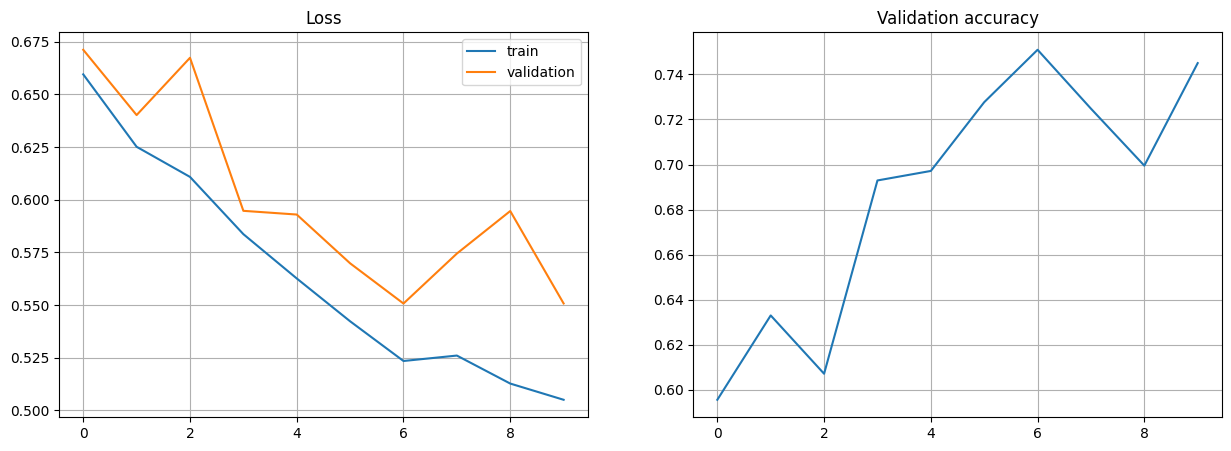

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

# Task 2: Fine-tuning

## In practice it is easier to use pre-trained NN

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/ft.jpg?raw=1" width="600">

We may see, that our current model performs quite well even after a small number of training epochs.

But for more complicated image classification or other computer vision tasks, it may be difficult to train CNN model from scratch.

State-of-the-art models consist of huge number of layers (100-200 convolutional blocks) and require powerful hardware to converge.

Thankfully, there are lots of pre-trained models available to be used for your own task, only slightly changing some of the final layers to your data.

This is called fine-tuning.

Let's try to load a pre-trained [ResNet-18](https://arxiv.org/abs/1512.03385) model from torch archive and fine-tune its final layers.

### ResNet (Shortcut + Batch Normalization)

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/resnet.png?raw=1" width="800">

In [ ]:
# Load pre-trained model
model_resnet18 = torchvision.models.resnet18(pretrained=True)

# Disable gradient updates for all the layers except  the final layer
for p in model_resnet18.parameters():
    p.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, NUM_CLASSES, bias=False)

# Use available device for calculations
model_resnet18 = model_resnet18.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


In [ ]:
summary(model_resnet18, (1, N_CHANNELS, SIZE_H, SIZE_W), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 48, 48]           (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 48, 48]           (128)
├─ReLU: 1-3                              [1, 64, 48, 48]           --
├─MaxPool2d: 1-4                         [1, 64, 24, 24]           --
├─Sequential: 1-5                        [1, 64, 24, 24]           --
│    └─BasicBlock: 2-1                   [1, 64, 24, 24]           --
│    │    └─Conv2d: 3-1                  [1, 64, 24, 24]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 24, 24]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 24, 24]           --
│    │    └─Conv2d: 3-4                  [1, 64, 24, 24]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 24, 24]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 24, 24]   

## Training (only for final layer)

In [ ]:
# Observe that only parameters of final layer are being optimized as opposed to before
opt_resnet = torch.optim.Adam(model_resnet18.fc.parameters(), lr=1e-3)

train_loss, val_loss, val_accuracy, best_model_resnet18 = train_model(
    model_resnet18, train_loader, val_loader, loss_fn, opt_resnet, 10
)

Epoch 1 of 10 took 32.490s
	  training loss: 0.461127
	validation loss: 0.387298
	validation accuracy: 81.3
Epoch 2 of 10 took 32.744s
	  training loss: 0.330097
	validation loss: 0.356202
	validation accuracy: 83.3
Epoch 3 of 10 took 32.485s
	  training loss: 0.310613
	validation loss: 0.339227
	validation accuracy: 84.1
Epoch 4 of 10 took 31.480s
	  training loss: 0.293065
	validation loss: 0.333401
	validation accuracy: 84.5
Epoch 5 of 10 took 31.021s
	  training loss: 0.284496
	validation loss: 0.337002
	validation accuracy: 84.8
Epoch 6 of 10 took 32.692s
	  training loss: 0.276826
	validation loss: 0.326728
	validation accuracy: 84.5
Epoch 7 of 10 took 32.852s
	  training loss: 0.279058
	validation loss: 0.324360
	validation accuracy: 85.0
Epoch 8 of 10 took 32.841s
	  training loss: 0.272896
	validation loss: 0.323592
	validation accuracy: 85.4
Epoch 9 of 10 took 31.355s
	  training loss: 0.266866
	validation loss: 0.320129
	validation accuracy: 85.5
Epoch 10 of 10 took 31.968s


## Evaluation

In [ ]:
val_stats = test_model(best_model_resnet18, val_loader, "validation")
test_stats = test_model(best_model_resnet18, test_loader, "test")

Results:
    validation accuracy: 85.65 %
  Good!
Results:
    test accuracy: 86.49 %
  Good!


## Use your own image

In [ ]:
from skimage.io import imread
from skimage.transform import resize


src_1_fp = r"img/example_1.png"
src_2_fp = r"img/example_2.png"

src_1 = imread(src_1_fp)
src_2 = imread(src_2_fp)

resized_1 = resize(src_1, (SIZE_H, SIZE_W), mode="reflect")
resized_2 = resize(src_2, (SIZE_H, SIZE_W), mode="reflect")

# convert to torch.Tensor
tensor_1 = torch.Tensor(
    np.transpose((resized_1 / 255 - image_mean) / image_std, [2, 0, 1])[np.newaxis, :, :, :]
).to(device)
tensor_2 = torch.Tensor(
    np.transpose((resized_2 / 255 - image_mean) / image_std, [2, 0, 1])[np.newaxis, :, :, :]
).to(device)

# 'cat' scores
score_1 = F.softmax(best_model_resnet18(tensor_1), 1)[0][0].detach().cpu().numpy()
score_2 = F.softmax(best_model_resnet18(tensor_2), 1)[0][0].detach().cpu().numpy()

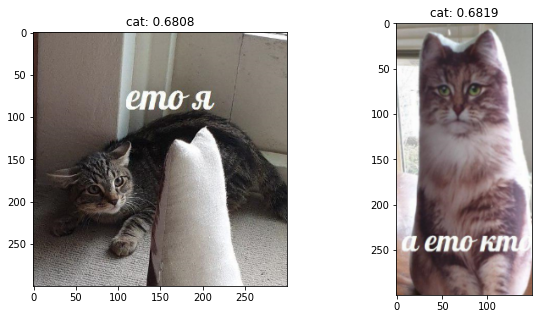

In [ ]:
get_label = lambda x: ("cat" if x > 0.5 else "dog") + ": {:.4f}".format(x)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(src_1)
plt.title(get_label(score_1))
plt.subplot(122)
plt.imshow(src_2)
plt.title(get_label(score_2))
plt.show()

```
```


# Task 3: adding normalization and different model initialization
## Let's get back to hard work
* Improve the task 1 CNN architecture  with the following:
  * Add batch norm (with default params) between convolution and ReLU
    * nn.BatchNorm*d (1d for dense, 2d for conv)
    * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least __80%__ validation accuracy at peak.
* Use the following model class to simplify the inference


To know more about **batch_norm** and **data covariate shift**

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

https://www.youtube.com/watch?v=nUUqwaxLnWs

In [ ]:
# Custom model class


def conv_block_3x3(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )


class MyModel(torch.nn.Module):
    def __init__(self, in_feature):
        super(MyModel, self).__init__()

        self.model = nn.Sequential(
            conv_block_3x3(3, 64),
            nn.MaxPool2d(2),
            conv_block_3x3(64, 64),
            nn.MaxPool2d(2),
            conv_block_3x3(64, 64),
            nn.MaxPool2d(2),
            conv_block_3x3(64, 128),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
        )
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Sequential(
            nn.Linear(128, EMBEDDING_SIZE, bias=False),
            nn.BatchNorm1d(EMBEDDING_SIZE),
            nn.ReLU(),
        )
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES, bias=False), nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.pred(x)
        return x

In [ ]:
# outputs are here for convenience
model_cnn_norm = MyModel(3)
summary(model_cnn_norm, (3, SIZE_H, SIZE_W), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,728
       BatchNorm2d-2           [-1, 64, 96, 96]             128
              ReLU-3           [-1, 64, 96, 96]               0
         MaxPool2d-4           [-1, 64, 48, 48]               0
            Conv2d-5           [-1, 64, 48, 48]          36,864
       BatchNorm2d-6           [-1, 64, 48, 48]             128
              ReLU-7           [-1, 64, 48, 48]               0
         MaxPool2d-8           [-1, 64, 24, 24]               0
            Conv2d-9           [-1, 64, 24, 24]          36,864
      BatchNorm2d-10           [-1, 64, 24, 24]             128
             ReLU-11           [-1, 64, 24, 24]               0
        MaxPool2d-12           [-1, 64, 12, 12]               0
           Conv2d-13          [-1, 128, 12, 12]          73,728
      BatchNorm2d-14          [-1, 128,

## Training

In [ ]:
model_cnn_norm = model_cnn_norm.to(device)
opt_norm = torch.optim.Adam(model_cnn_norm.parameters(), lr=1e-3)
opt_norm.zero_grad()

train_loss, val_loss, val_accuracy, best_model_norm = train_model(
    model_cnn_norm, train_loader, val_loader, loss_fn, opt_norm, 20
)

Epoch 1 of 20 took 45.273s
	  training loss: 0.599766
	validation loss: 0.652945
	validation accuracy: 62.8
Epoch 2 of 20 took 45.796s
	  training loss: 0.513656
	validation loss: 0.682920
	validation accuracy: 62.8
Epoch 3 of 20 took 45.415s
	  training loss: 0.475170
	validation loss: 0.861899
	validation accuracy: 60.0
Epoch 4 of 20 took 45.904s
	  training loss: 0.439741
	validation loss: 0.652099
	validation accuracy: 66.9
Epoch 5 of 20 took 45.568s
	  training loss: 0.416954
	validation loss: 0.821253
	validation accuracy: 60.0
Epoch 6 of 20 took 45.538s
	  training loss: 0.386723
	validation loss: 0.457171
	validation accuracy: 78.4
Epoch 7 of 20 took 45.823s
	  training loss: 0.354171
	validation loss: 0.410063
	validation accuracy: 81.7
Epoch 8 of 20 took 45.631s
	  training loss: 0.324599
	validation loss: 0.953119
	validation accuracy: 64.1
Epoch 9 of 20 took 45.892s
	  training loss: 0.304060
	validation loss: 0.530857
	validation accuracy: 77.2
Epoch 10 of 20 took 46.067s


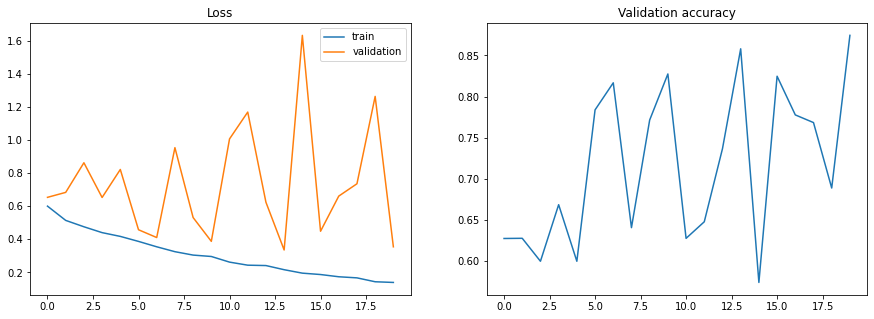

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Evaluation

In [ ]:
val_stats = test_model(best_model_norm, val_loader, "validation")
test_stats = test_model(best_model_norm, test_loader, "test")

Results:
    validation accuracy: 87.44 %
  Good!
Results:
    test accuracy: 88.37 %
  Good!



```

```

```

```

```

```

```

```

```

```

```

```

```

```
# Task 4: Data Augmentation (bonus area)

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly changes image color (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/augmentation.png?raw=1" width="500">

In [ ]:
transformer_augmented = transforms.Compose(
    [
        transforms.RandomRotation(30, fill=tuple((255 * np.array(image_mean)).astype(int))),
        transforms.Resize((5 * SIZE_H // 4, 5 * SIZE_H // 4)),
        transforms.RandomCrop((SIZE_H, SIZE_W)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.3),
        transforms.ToTensor(),
        transforms.Normalize(image_mean, image_std),
    ]
)

In [ ]:
# Load dataset using ImageFolder using transformer with augmentation
# Note: We do not use augmentation for validation or testing
train_dataset_aug = torchvision.datasets.ImageFolder(
    os.path.join(DATA_PATH, "train_11k"), transform=transformer_augmented
)
train_aug_loader = torch.utils.data.DataLoader(
    train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

Let's look at some image examples

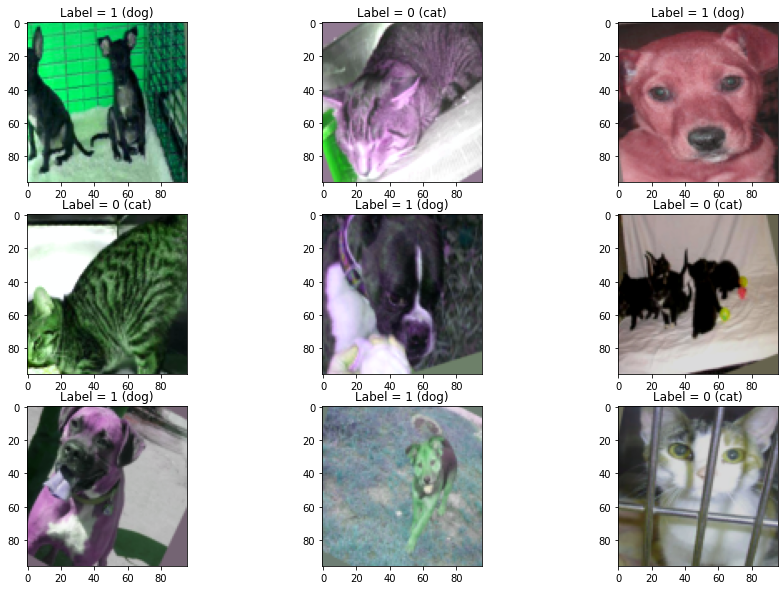

In [ ]:
plot_from_loader(train_aug_loader)

Note that we did not change test_dataset, as we do not need to augment image data in it.

Let's retrain our model, saving it to another variable

## Training

In [ ]:
model_cnn_aug = MyModel(3).to(device)
opt = torch.optim.Adam(model_cnn_aug.parameters(), lr=1e-3)
opt.zero_grad()

train_loss, val_loss, val_accuracy, best_model_aug = train_model(
    model_cnn_aug, train_aug_loader, val_loader, loss_fn, opt, EPOCH_NUM
)

Epoch 1 of 20 took 66.801s
	  training loss: 0.649600
	validation loss: 0.725847
	validation accuracy: 55.1
Epoch 2 of 20 took 66.971s
	  training loss: 0.611717
	validation loss: 0.657398
	validation accuracy: 62.1
Epoch 3 of 20 took 67.922s
	  training loss: 0.579929
	validation loss: 0.643520
	validation accuracy: 63.4
Epoch 4 of 20 took 67.745s
	  training loss: 0.566190
	validation loss: 0.622475
	validation accuracy: 66.4
Epoch 5 of 20 took 67.310s
	  training loss: 0.553849
	validation loss: 0.571608
	validation accuracy: 72.4
Epoch 6 of 20 took 66.906s
	  training loss: 0.547044
	validation loss: 0.550020
	validation accuracy: 74.6
Epoch 7 of 20 took 66.883s
	  training loss: 0.538769
	validation loss: 0.566140
	validation accuracy: 72.9
Epoch 8 of 20 took 67.333s
	  training loss: 0.529117
	validation loss: 0.584542
	validation accuracy: 70.7
Epoch 9 of 20 took 66.830s
	  training loss: 0.527874
	validation loss: 0.632737
	validation accuracy: 65.7
Epoch 10 of 20 took 66.839s


In [ ]:
## Evaluation

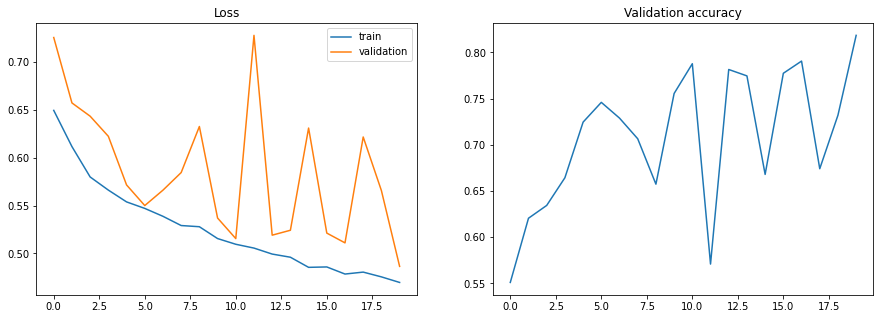

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
val_stats = test_model(model_cnn_aug, val_loader, "validation")
test_stats = test_model(model_cnn_aug, test_loader, "test")

Results:
    validation accuracy: 81.83 %
  Good!
Results:
    test accuracy: 83.06 %
  Good!


## Dark Magic (some practical tricks and issues)

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/dm.png?raw=1" width="600">